In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('../code')

In [3]:
from model import get_model
import torch
from predict import *
from glob import glob
import matplotlib.pyplot as plt
from data.functional import collate_mask_fn
import numpy as np
from utils.metrics import cal_mAP

In [5]:
filelist = []

for root, dirs, files in os.walk('../params/effunet_b4'):
    for file in files:
        #append the file name to the list
        filelist.append(os.path.join(root,file))
print('\n'.join(filelist))

../params/effunet_b4/f03_exp_spaattn_adamw/ckpt/last.ckpt
../params/effunet_b4/f03_exp_spaattn_adamw/ckpt/epoch=39-precision=0.8371.ckpt
../params/effunet_b4/f00_exp_spaattn_adamw/ckpt/last.ckpt
../params/effunet_b4/f00_exp_spaattn_adamw/ckpt/epoch=58-precision=0.8067.ckpt
../params/effunet_b4/f00_exp_spaattn_adamw/ckpt/epoch=47-precision=0.8506.ckpt
../params/effunet_b4/f02_exp_spaattn_adamw/ckpt/last.ckpt
../params/effunet_b4/f02_exp_spaattn_adamw/ckpt/epoch=30-precision=0.8508.ckpt
../params/effunet_b4/f00_exp_mish/ckpt/last.ckpt
../params/effunet_b4/f00_exp_mish/ckpt/epoch=77-precision=0.8416.ckpt
../params/effunet_b4/f00_exp_sgd_1/ckpt/epoch=71-precision=0.8525.ckpt
../params/effunet_b4/f00_exp_sgd_1/ckpt/last.ckpt
../params/effunet_b4/f00_exp_sgd_1/ckpt/last (copy).ckpt
../params/effunet_b4/f00_exp_spaattn_4/ckpt/last.ckpt
../params/effunet_b4/f00_exp_spaattn_4/ckpt/epoch=49-precision=0.8386.ckpt
../params/effunet_b4/f00_exp_spaattn_4/ckpt/epoch=54-precision=0.8438.ckpt
../params

In [6]:
model = get_model('effunet_b4')

In [7]:
pretrain = torch.load('../params/effunet_b4/f00_exp_spaattn_4/ckpt/epoch=54-precision=0.8438.ckpt')
state_dict = {k[5:]:v for k,v in pretrain['state_dict'].items()}

In [8]:
model.load_state_dict(state_dict)

<All keys matched successfully>

## Find best threshold

In [9]:
root_ds = '../dataset'
cross_validation = True
fold_val_idx = 0

# DataFrame chứa toàn bộ train_id và đã được chia fold
df = pd.read_csv(os.path.join(root_ds, 'folds.csv'), index_col='id')
total_sample = len(df.index)
print('Total numper of sample:', total_sample)

val_df = df.loc[df.fold == 0].reset_index()
val_ds = TGSSaltDataset(root_ds, val_df, transforms=TGSTransform(augment_strategy=0)) # Không augmentation cho valid set
val_dl = DataLoader(val_ds, batch_size=16, num_workers=4, collate_fn=collate_mask_fn, pin_memory=True)

Total numper of sample: 4000


In [10]:
preds_test = pred_all(model, val_dl, True, is_valid=True)
preds_test = torch.cat(preds_test, dim=0).unsqueeze(1)
preds_101 = resize_to_orig(preds_test)

  0%|          | 0/51 [00:00<?, ?it/s]/python/lib/python3.8/site-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
100%|██████████| 51/51 [00:11<00:00,  4.26it/s]


In [11]:
del preds_test
val_ds.transforms = None
val_df["masks"] = [np.array(val_ds[idx][1]) / 255 for idx in val_df.index]
val_df.head()
true_masks = torch.tensor(val_df['masks'])
del df, val_df, val_ds, val_dl

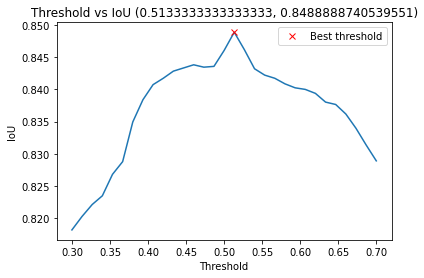

In [12]:
thresholds = np.linspace(0.3, 0.7, 31)
mAPs = np.array([cal_mAP(preds_101, true_masks, threshold) for threshold in thresholds])
threshold_best_index = np.argmax(mAPs) 
mAP_best = mAPs[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, mAPs)
plt.plot(threshold_best, mAP_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, mAP_best))
plt.legend()

## Submit

In [13]:
add_depth=False
resize_pad=False 
tta_flip=True
data_root = '../dataset'
batch_size=16
num_workers=2
pred_threshold=0.5

df = pd.read_csv(os.path.join(data_root, 'folds.csv'), index_col='id')
depths = pd.read_csv(os.path.join(data_root, 'depths.csv'), index_col='id')
test_df = depths.loc[~depths.index.isin(df.index)].reset_index()
ds_test = TGSSaltDataset(data_root, test_df, image_set='test', transforms=TGSTransform(augment_strategy=0, add_depth=add_depth,resize_pad=resize_pad))
test_dl = DataLoader(ds_test,
                      shuffle=False,
                      batch_size=batch_size,
                      num_workers=num_workers,
                      pin_memory=True)
preds_test = pred_all(model, test_dl, tta_flip)
preds_test = torch.cat(preds_test, dim=0).unsqueeze(1)
preds_101 = resize_to_orig(preds_test)

  0%|          | 0/1125 [00:00<?, ?it/s]/python/lib/python3.8/site-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
100%|██████████| 1125/1125 [04:21<00:00,  4.30it/s]


In [16]:
sub = build_summission((preds_101.cpu().numpy() > 0.5133).astype(int), ds_test.image_ids)

Encode time = 1.0783307552337646 s


In [17]:
sub.to_csv('effb4_spaatt_fpa_lovaszhinge_loss_tta.csv')

In [30]:
# sub = submit_model(model, '../dataset', add_depth=False, resize_pad=False, tta_flip=True, pred_threshold=0.55)

In [23]:
sub.to_csv('effb4_lovaszhinge_loss_noscheduler_tta.csv')

In [51]:
import gc
gc.collect()

2310